In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print("ResBlock:", x.shape)
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)

            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


In [3]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # print("UnetDown:", x.shape)
        return self.model(x)

In [4]:
import torch.nn.functional as F

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # print("UnetUp:", x.size())
        # print(x.size(), skip.size())
        
        if x.shape[3] == 63:
            x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)

        x = torch.cat((x, skip), 1)
        # print("Size of concatenated tensor:", x.size())

        x = self.model(x)
        return x
    
    
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # print("EmbedFC:", x.shape)
        x = x.view(-1, self.input_dim)
        return self.model(x)


In [5]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 128, n_classes=3):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), 
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )
        
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on
        # print("ContextUnet", x.shape)
        
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1+ temb1, down2) 
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [6]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [7]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """
        # print("DDPM:", x.shape)
        
        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        # print("DDPM_context_mask:", context_mask.shape)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,3).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Using device: cuda

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 0.2 GB
Cached:    14.6 GB
epoch 0


loss: 0.6955: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep0_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep0_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep0_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep0_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep0_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep0_w2.0.gif
epoch 1


loss: 0.1480: 100%|█████████████████████████████| 15/15 [00:02<00:00,  7.36it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep1_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep1_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep1_w2.0.png
epoch 2


loss: 0.1528: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.69it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep2_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep2_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep2_w2.0.png
epoch 3


loss: 0.0798: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep3_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep3_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep3_w2.0.png
epoch 4


loss: 0.1034: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.94it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep4_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep4_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep4_w2.0.png
epoch 5


loss: 0.1783: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.73it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep5_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep5_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep5_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep5_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep5_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep5_w2.0.gif
epoch 6


loss: 0.1308: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep6_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep6_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep6_w2.0.png
epoch 7


loss: 0.0889: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep7_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep7_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep7_w2.0.png
epoch 8


loss: 0.0876: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.92it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep8_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep8_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep8_w2.0.png
epoch 9


loss: 0.0981: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.67it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep9_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep9_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep9_w2.0.png
epoch 10


loss: 0.1296: 100%|█████████████████████████████| 15/15 [00:01<00:00,  8.03it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep10_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep10_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep10_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep10_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep10_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep10_w2.0.gif
epoch 11


loss: 0.0974: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep11_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep11_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep11_w2.0.png
epoch 12


loss: 0.0961: 100%|█████████████████████████████| 15/15 [00:01<00:00,  8.03it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep12_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep12_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep12_w2.0.png
epoch 13


loss: 0.0693: 100%|█████████████████████████████| 15/15 [00:01<00:00,  8.05it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep13_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep13_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep13_w2.0.png
epoch 14


loss: 0.1326: 100%|█████████████████████████████| 15/15 [00:01<00:00,  8.05it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep14_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep14_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep14_w2.0.png
epoch 15


loss: 0.0999: 100%|█████████████████████████████| 15/15 [00:01<00:00,  8.04it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep15_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep15_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep15_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep15_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep15_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep15_w2.0.gif
epoch 16


loss: 0.1611: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.93it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep16_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep16_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep16_w2.0.png
epoch 17


loss: 0.0874: 100%|█████████████████████████████| 15/15 [00:01<00:00,  8.00it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep17_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep17_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep17_w2.0.png
epoch 18


loss: 0.0760: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.91it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep18_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep18_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep18_w2.0.png
epoch 19


loss: 0.0988: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep19_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep19_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep19_w2.0.png
epoch 20


loss: 0.1013: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.93it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep20_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep20_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep20_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep20_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep20_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep20_w2.0.gif
epoch 21


loss: 0.1484: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep21_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep21_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep21_w2.0.png
epoch 22


loss: 0.1102: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.92it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep22_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep22_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep22_w2.0.png
epoch 23


loss: 0.0487: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep23_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep23_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep23_w2.0.png
epoch 24


loss: 0.1045: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.92it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep24_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep24_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep24_w2.0.png
epoch 25


loss: 0.0727: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep25_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep25_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep25_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep25_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep25_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep25_w2.0.gif
epoch 26


loss: 0.2460: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep26_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep26_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep26_w2.0.png
epoch 27


loss: 0.0794: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep27_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep27_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep27_w2.0.png
epoch 28


loss: 0.1236: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.95it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep28_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep28_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep28_w2.0.png
epoch 29


loss: 0.1065: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep29_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep29_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep29_w2.0.png
epoch 30


loss: 0.1373: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep30_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep30_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep30_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep30_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep30_w2.0.png


/tmp/ipykernel_1151969/2846862723.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))


saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep30_w2.0.gif
epoch 31


loss: 0.0617: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep31_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep31_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep31_w2.0.png
epoch 32


loss: 0.0694: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.96it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep32_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep32_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep32_w2.0.png
epoch 33


loss: 0.0615: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep33_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep33_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep33_w2.0.png
epoch 34


loss: 0.1401: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep34_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep34_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep34_w2.0.png
epoch 35


loss: 0.0587: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep35_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep35_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep35_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep35_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep35_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep35_w2.0.gif
epoch 36


loss: 0.0701: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep36_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep36_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep36_w2.0.png
epoch 37


loss: 0.1060: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep37_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep37_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep37_w2.0.png
epoch 38


loss: 0.1637: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep38_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep38_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep38_w2.0.png
epoch 39


loss: 0.0852: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep39_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep39_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep39_w2.0.png
epoch 40


loss: 0.0856: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep40_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep40_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep40_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep40_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep40_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep40_w2.0.gif
epoch 41


loss: 0.1147: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep41_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep41_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep41_w2.0.png
epoch 42


loss: 0.0749: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep42_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep42_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep42_w2.0.png
epoch 43


loss: 0.0837: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.92it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep43_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep43_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep43_w2.0.png
epoch 44


loss: 0.0694: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep44_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep44_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep44_w2.0.png
epoch 45


loss: 0.1275: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep45_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep45_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep45_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep45_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep45_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep45_w2.0.gif
epoch 46


loss: 0.1001: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep46_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep46_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep46_w2.0.png
epoch 47


loss: 0.0817: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.91it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep47_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep47_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep47_w2.0.png
epoch 48


loss: 0.1249: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep48_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep48_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep48_w2.0.png
epoch 49


loss: 0.0711: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.94it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep49_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep49_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep49_w2.0.png
epoch 50


loss: 0.1214: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.92it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep50_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep50_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep50_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep50_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep50_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep50_w2.0.gif
epoch 51


loss: 0.0761: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep51_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep51_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep51_w2.0.png
epoch 52


loss: 0.0713: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep52_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep52_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep52_w2.0.png
epoch 53


loss: 0.0804: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep53_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep53_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep53_w2.0.png
epoch 54


loss: 0.0558: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.91it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep54_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep54_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep54_w2.0.png
epoch 55


loss: 0.1142: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep55_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep55_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep55_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep55_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep55_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep55_w2.0.gif
epoch 56


loss: 0.0419: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.92it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep56_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep56_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep56_w2.0.png
epoch 57


loss: 0.0795: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep57_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep57_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep57_w2.0.png
epoch 58


loss: 0.0951: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.94it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep58_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep58_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep58_w2.0.png
epoch 59


loss: 0.1327: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep59_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep59_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep59_w2.0.png
epoch 60


loss: 0.0607: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep60_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep60_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep60_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep60_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep60_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep60_w2.0.gif
epoch 61


loss: 0.0667: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep61_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep61_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep61_w2.0.png
epoch 62


loss: 0.0769: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep62_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep62_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep62_w2.0.png
epoch 63


loss: 0.0662: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep63_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep63_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep63_w2.0.png
epoch 64


loss: 0.0741: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.91it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep64_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep64_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep64_w2.0.png
epoch 65


loss: 0.1175: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep65_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep65_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep65_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep65_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep65_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep65_w2.0.gif
epoch 66


loss: 0.0855: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep66_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep66_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep66_w2.0.png
epoch 67


loss: 0.0665: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep67_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep67_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep67_w2.0.png
epoch 68


loss: 0.1449: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep68_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep68_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep68_w2.0.png
epoch 69


loss: 0.0972: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep69_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep69_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep69_w2.0.png
epoch 70


loss: 0.1058: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep70_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep70_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep70_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep70_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep70_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep70_w2.0.gif
epoch 71


loss: 0.1149: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.79it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep71_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep71_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep71_w2.0.png
epoch 72


loss: 0.0657: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep72_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep72_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep72_w2.0.png
epoch 73


loss: 0.1137: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep73_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep73_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep73_w2.0.png
epoch 74


loss: 0.0722: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.94it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep74_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep74_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep74_w2.0.png
epoch 75


loss: 0.0823: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep75_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep75_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep75_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep75_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep75_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep75_w2.0.gif
epoch 76


loss: 0.0721: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep76_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep76_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep76_w2.0.png
epoch 77


loss: 0.0685: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep77_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep77_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep77_w2.0.png
epoch 78


loss: 0.0828: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep78_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep78_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep78_w2.0.png
epoch 79


loss: 0.0641: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep79_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep79_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep79_w2.0.png
epoch 80


loss: 0.1842: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep80_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep80_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep80_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep80_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep80_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep80_w2.0.gif
epoch 81


loss: 0.0996: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.93it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep81_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep81_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep81_w2.0.png
epoch 82


loss: 0.1006: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.79it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep82_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep82_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep82_w2.0.png
epoch 83


loss: 0.0847: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep83_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep83_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep83_w2.0.png
epoch 84


loss: 0.0846: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep84_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep84_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep84_w2.0.png
epoch 85


loss: 0.0741: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep85_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep85_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep85_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep85_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep85_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep85_w2.0.gif
epoch 86


loss: 0.1887: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep86_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep86_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep86_w2.0.png
epoch 87


loss: 0.0879: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.79it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep87_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep87_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep87_w2.0.png
epoch 88


loss: 0.0579: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep88_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep88_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep88_w2.0.png
epoch 89


loss: 0.0833: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep89_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep89_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep89_w2.0.png
epoch 90


loss: 0.1074: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.96it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep90_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep90_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep90_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep90_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep90_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep90_w2.0.gif
epoch 91


loss: 0.1261: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep91_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep91_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep91_w2.0.png
epoch 92


loss: 0.1325: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep92_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep92_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep92_w2.0.png
epoch 93


loss: 0.0717: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep93_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep93_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep93_w2.0.png
epoch 94


loss: 0.0777: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep94_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep94_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep94_w2.0.png
epoch 95


loss: 0.0779: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep95_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep95_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep95_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep95_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep95_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep95_w2.0.gif
epoch 96


loss: 0.1239: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep96_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep96_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep96_w2.0.png
epoch 97


loss: 0.0552: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep97_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep97_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep97_w2.0.png
epoch 98


loss: 0.0846: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep98_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep98_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep98_w2.0.png
epoch 99


loss: 0.0556: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep99_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep99_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep99_w2.0.png
epoch 100


loss: 0.0761: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep100_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep100_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep100_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep100_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep100_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep100_w2.0.gif
epoch 101


loss: 0.0846: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep101_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep101_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep101_w2.0.png
epoch 102


loss: 0.0547: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep102_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep102_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep102_w2.0.png
epoch 103


loss: 0.0965: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep103_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep103_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep103_w2.0.png
epoch 104


loss: 0.0893: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep104_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep104_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep104_w2.0.png
epoch 105


loss: 0.0759: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.92it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep105_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep105_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep105_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep105_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep105_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep105_w2.0.gif
epoch 106


loss: 0.0686: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep106_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep106_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep106_w2.0.png
epoch 107


loss: 0.1291: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep107_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep107_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep107_w2.0.png
epoch 108


loss: 0.0986: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep108_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep108_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep108_w2.0.png
epoch 109


loss: 0.0617: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep109_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep109_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep109_w2.0.png
epoch 110


loss: 0.0894: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep110_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep110_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep110_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep110_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep110_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep110_w2.0.gif
epoch 111


loss: 0.1080: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep111_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep111_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep111_w2.0.png
epoch 112


loss: 0.0977: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep112_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep112_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep112_w2.0.png
epoch 113


loss: 0.0797: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.94it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep113_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep113_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep113_w2.0.png
epoch 114


loss: 0.0639: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep114_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep114_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep114_w2.0.png
epoch 115


loss: 0.0440: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep115_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep115_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep115_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep115_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep115_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep115_w2.0.gif
epoch 116


loss: 0.1282: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep116_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep116_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep116_w2.0.png
epoch 117


loss: 0.0588: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep117_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep117_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep117_w2.0.png
epoch 118


loss: 0.0919: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep118_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep118_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep118_w2.0.png
epoch 119


loss: 0.0495: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep119_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep119_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep119_w2.0.png
epoch 120


loss: 0.1355: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep120_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep120_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep120_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep120_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep120_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep120_w2.0.gif
epoch 121


loss: 0.0499: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep121_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep121_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep121_w2.0.png
epoch 122


loss: 0.0608: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep122_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep122_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep122_w2.0.png
epoch 123


loss: 0.1044: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.91it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep123_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep123_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep123_w2.0.png
epoch 124


loss: 0.0788: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep124_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep124_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep124_w2.0.png
epoch 125


loss: 0.0865: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep125_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep125_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep125_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep125_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep125_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep125_w2.0.gif
epoch 126


loss: 0.0963: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep126_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep126_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep126_w2.0.png
epoch 127


loss: 0.1232: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep127_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep127_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep127_w2.0.png
epoch 128


loss: 0.0705: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep128_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep128_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep128_w2.0.png
epoch 129


loss: 0.1410: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep129_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep129_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep129_w2.0.png
epoch 130


loss: 0.1194: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.79it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep130_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep130_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep130_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep130_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep130_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep130_w2.0.gif
epoch 131


loss: 0.1099: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep131_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep131_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep131_w2.0.png
epoch 132


loss: 0.0512: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep132_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep132_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep132_w2.0.png
epoch 133


loss: 0.0770: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep133_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep133_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep133_w2.0.png
epoch 134


loss: 0.1477: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep134_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep134_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep134_w2.0.png
epoch 135


loss: 0.1342: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep135_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep135_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep135_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep135_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep135_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep135_w2.0.gif
epoch 136


loss: 0.0503: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.86it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep136_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep136_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep136_w2.0.png
epoch 137


loss: 0.1006: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep137_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep137_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep137_w2.0.png
epoch 138


loss: 0.0643: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep138_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep138_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep138_w2.0.png
epoch 139


loss: 0.0618: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep139_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep139_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep139_w2.0.png
epoch 140


loss: 0.1273: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep140_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep140_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep140_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep140_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep140_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep140_w2.0.gif
epoch 141


loss: 0.1537: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep141_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep141_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep141_w2.0.png
epoch 142


loss: 0.0924: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep142_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep142_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep142_w2.0.png
epoch 143


loss: 0.0646: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep143_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep143_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep143_w2.0.png
epoch 144


loss: 0.0552: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep144_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep144_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep144_w2.0.png
epoch 145


loss: 0.1017: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep145_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep145_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep145_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep145_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep145_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep145_w2.0.gif
epoch 146


loss: 0.0625: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.75it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep146_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep146_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep146_w2.0.png
epoch 147


loss: 0.0626: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep147_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep147_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep147_w2.0.png
epoch 148


loss: 0.0390: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep148_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep148_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep148_w2.0.png
epoch 149


loss: 0.0726: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep149_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep149_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep149_w2.0.png
epoch 150


loss: 0.0664: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.72it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep150_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep150_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep150_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep150_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep150_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep150_w2.0.gif
epoch 151


loss: 0.0804: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.96it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep151_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep151_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep151_w2.0.png
epoch 152


loss: 0.0494: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.93it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep152_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep152_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep152_w2.0.png
epoch 153


loss: 0.0682: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep153_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep153_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep153_w2.0.png
epoch 154


loss: 0.1274: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep154_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep154_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep154_w2.0.png
epoch 155


loss: 0.0710: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep155_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep155_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep155_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep155_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep155_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep155_w2.0.gif
epoch 156


loss: 0.1201: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep156_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep156_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep156_w2.0.png
epoch 157


loss: 0.0607: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep157_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep157_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep157_w2.0.png
epoch 158


loss: 0.0982: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.70it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep158_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep158_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep158_w2.0.png
epoch 159


loss: 0.0799: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep159_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep159_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep159_w2.0.png
epoch 160


loss: 0.1279: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.74it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep160_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep160_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep160_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep160_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep160_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep160_w2.0.gif
epoch 161


loss: 0.0650: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep161_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep161_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep161_w2.0.png
epoch 162


loss: 0.0761: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep162_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep162_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep162_w2.0.png
epoch 163


loss: 0.0704: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep163_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep163_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep163_w2.0.png
epoch 164


loss: 0.1177: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.74it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep164_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep164_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep164_w2.0.png
epoch 165


loss: 0.0909: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep165_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep165_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep165_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep165_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep165_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep165_w2.0.gif
epoch 166


loss: 0.1150: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep166_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep166_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep166_w2.0.png
epoch 167


loss: 0.0688: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep167_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep167_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep167_w2.0.png
epoch 168


loss: 0.0681: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep168_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep168_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep168_w2.0.png
epoch 169


loss: 0.0639: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep169_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep169_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep169_w2.0.png
epoch 170


loss: 0.1005: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep170_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep170_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep170_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep170_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep170_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep170_w2.0.gif
epoch 171


loss: 0.1204: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.74it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep171_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep171_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep171_w2.0.png
epoch 172


loss: 0.0893: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep172_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep172_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep172_w2.0.png
epoch 173


loss: 0.0750: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep173_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep173_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep173_w2.0.png
epoch 174


loss: 0.1702: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep174_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep174_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep174_w2.0.png
epoch 175


loss: 0.0728: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep175_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep175_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep175_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep175_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep175_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep175_w2.0.gif
epoch 176


loss: 0.1125: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep176_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep176_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep176_w2.0.png
epoch 177


loss: 0.0594: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep177_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep177_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep177_w2.0.png
epoch 178


loss: 0.0400: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep178_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep178_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep178_w2.0.png
epoch 179


loss: 0.1083: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep179_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep179_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep179_w2.0.png
epoch 180


loss: 0.1614: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep180_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep180_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep180_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep180_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep180_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep180_w2.0.gif
epoch 181


loss: 0.0751: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.75it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep181_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep181_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep181_w2.0.png
epoch 182


loss: 0.1281: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.79it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep182_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep182_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep182_w2.0.png
epoch 183


loss: 0.0567: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep183_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep183_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep183_w2.0.png
epoch 184


loss: 0.0947: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep184_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep184_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep184_w2.0.png
epoch 185


loss: 0.0913: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep185_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep185_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep185_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep185_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep185_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep185_w2.0.gif
epoch 186


loss: 0.0898: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep186_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep186_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep186_w2.0.png
epoch 187


loss: 0.0760: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.90it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep187_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep187_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep187_w2.0.png
epoch 188


loss: 0.0576: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep188_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep188_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep188_w2.0.png
epoch 189


loss: 0.0601: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep189_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep189_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep189_w2.0.png
epoch 190


loss: 0.0796: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.87it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep190_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep190_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep190_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep190_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep190_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep190_w2.0.gif
epoch 191


loss: 0.1140: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep191_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep191_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep191_w2.0.png
epoch 192


loss: 0.0770: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep192_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep192_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep192_w2.0.png
epoch 193


loss: 0.1061: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep193_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep193_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep193_w2.0.png
epoch 194


loss: 0.0633: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep194_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep194_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep194_w2.0.png
epoch 195


loss: 0.0621: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep195_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep195_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep195_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep195_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep195_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep195_w2.0.gif
epoch 196


loss: 0.0711: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep196_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep196_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep196_w2.0.png
epoch 197


loss: 0.0756: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep197_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep197_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep197_w2.0.png
epoch 198


loss: 0.1247: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.75it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep198_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep198_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep198_w2.0.png
epoch 199


loss: 0.0633: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep199_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep199_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep199_w2.0.png
epoch 200


loss: 0.0480: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.85it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep200_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep200_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep200_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep200_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep200_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep200_w2.0.gif
epoch 201


loss: 0.0765: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.72it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep201_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep201_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep201_w2.0.png
epoch 202


loss: 0.1554: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep202_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep202_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep202_w2.0.png
epoch 203


loss: 0.0718: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep203_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep203_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep203_w2.0.png
epoch 204


loss: 0.1117: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep204_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep204_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep204_w2.0.png
epoch 205


loss: 0.0813: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep205_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep205_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep205_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep205_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep205_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep205_w2.0.gif
epoch 206


loss: 0.0632: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep206_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep206_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep206_w2.0.png
epoch 207


loss: 0.1142: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep207_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep207_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep207_w2.0.png
epoch 208


loss: 0.0631: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.74it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep208_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep208_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep208_w2.0.png
epoch 209


loss: 0.1551: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep209_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep209_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep209_w2.0.png
epoch 210


loss: 0.0688: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep210_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep210_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep210_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep210_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep210_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep210_w2.0.gif
epoch 211


loss: 0.0745: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep211_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep211_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep211_w2.0.png
epoch 212


loss: 0.0666: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep212_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep212_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep212_w2.0.png
epoch 213


loss: 0.0623: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep213_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep213_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep213_w2.0.png
epoch 214


loss: 0.0565: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.78it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep214_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep214_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep214_w2.0.png
epoch 215


loss: 0.0490: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep215_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep215_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep215_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep215_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep215_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep215_w2.0.gif
epoch 216


loss: 0.1006: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.73it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep216_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep216_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep216_w2.0.png
epoch 217


loss: 0.0587: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep217_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep217_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep217_w2.0.png
epoch 218


loss: 0.0413: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.73it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep218_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep218_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep218_w2.0.png
epoch 219


loss: 0.0531: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.84it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep219_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep219_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep219_w2.0.png
epoch 220


loss: 0.0477: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep220_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep220_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep220_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep220_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep220_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep220_w2.0.gif
epoch 221


loss: 0.0681: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.74it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep221_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep221_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep221_w2.0.png
epoch 222


loss: 0.1844: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep222_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep222_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep222_w2.0.png
epoch 223


loss: 0.0836: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep223_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep223_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep223_w2.0.png
epoch 224


loss: 0.0498: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep224_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep224_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep224_w2.0.png
epoch 225


loss: 0.2059: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.73it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep225_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep225_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep225_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep225_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep225_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep225_w2.0.gif
epoch 226


loss: 0.0872: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.74it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep226_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep226_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep226_w2.0.png
epoch 227


loss: 0.0714: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep227_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep227_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep227_w2.0.png
epoch 228


loss: 0.1572: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep228_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep228_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep228_w2.0.png
epoch 229


loss: 0.0919: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep229_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep229_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep229_w2.0.png
epoch 230


loss: 0.1665: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep230_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep230_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep230_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep230_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep230_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep230_w2.0.gif
epoch 231


loss: 0.1331: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.73it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep231_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep231_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep231_w2.0.png
epoch 232


loss: 0.0809: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep232_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep232_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep232_w2.0.png
epoch 233


loss: 0.0439: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.72it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep233_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep233_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep233_w2.0.png
epoch 234


loss: 0.1077: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.83it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep234_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep234_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep234_w2.0.png
epoch 235


loss: 0.0669: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.79it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep235_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep235_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep235_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep235_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep235_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep235_w2.0.gif
epoch 236


loss: 0.0616: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep236_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep236_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep236_w2.0.png
epoch 237


loss: 0.0677: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep237_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep237_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep237_w2.0.png
epoch 238


loss: 0.1876: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.77it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep238_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep238_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep238_w2.0.png
epoch 239


loss: 0.0561: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep239_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep239_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep239_w2.0.png
epoch 240


loss: 0.0772: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep240_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep240_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep240_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep240_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep240_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep240_w2.0.gif
epoch 241


loss: 0.0787: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.75it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep241_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep241_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep241_w2.0.png
epoch 242


loss: 0.0814: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep242_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep242_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep242_w2.0.png
epoch 243


loss: 0.0641: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep243_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep243_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep243_w2.0.png
epoch 244


loss: 0.0679: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.81it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep244_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep244_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep244_w2.0.png
epoch 245


loss: 0.0557: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.70it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep245_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep245_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep245_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep245_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep245_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep245_w2.0.gif
epoch 246


loss: 0.1046: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.72it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep246_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep246_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep246_w2.0.png
epoch 247


loss: 0.1538: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.82it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep247_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep247_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep247_w2.0.png
epoch 248


loss: 0.0626: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep248_w0.0.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep248_w0.5.png

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep248_w2.0.png
epoch 249


loss: 0.0802: 100%|█████████████████████████████| 15/15 [00:01<00:00,  7.80it/s]



saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep249_w0.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep249_w0.0.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep249_w0.5.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep249_w0.5.gif

saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/image_ep249_w2.0.png
saved image at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/gif_ep249_w2.0.gif
saved model at /home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/saved_models/model_249.pth


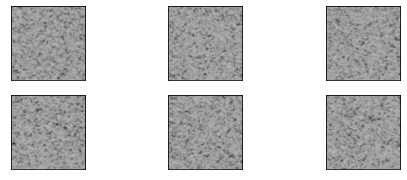

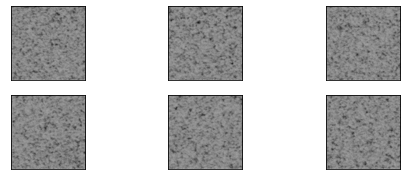

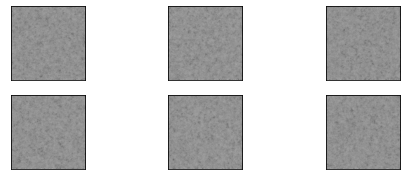

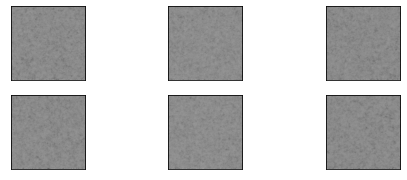

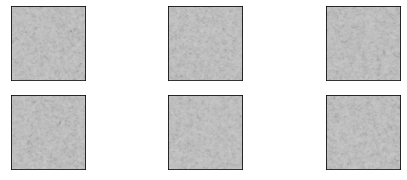

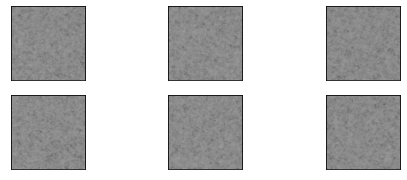

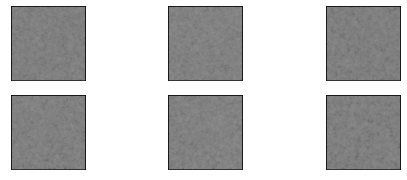

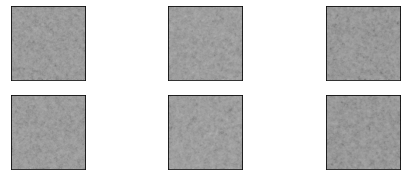

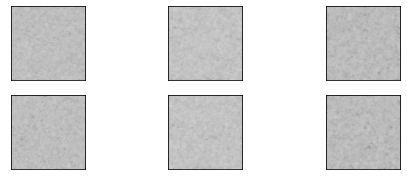

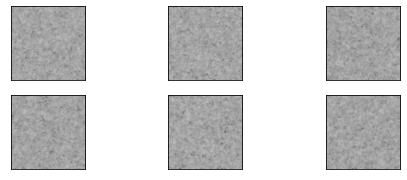

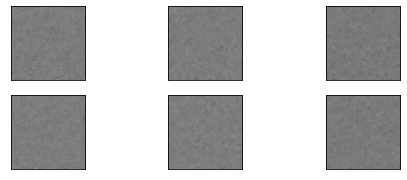

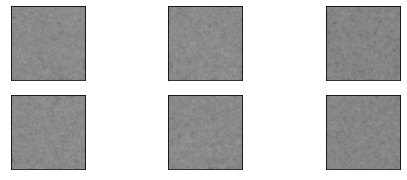

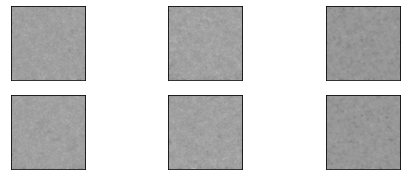

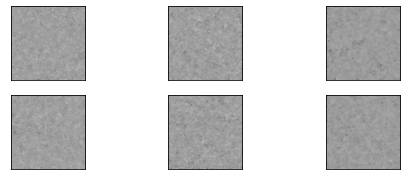

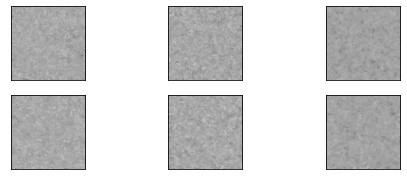

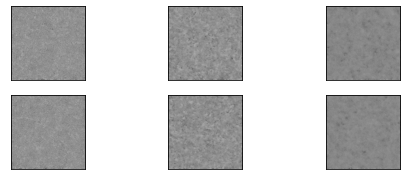

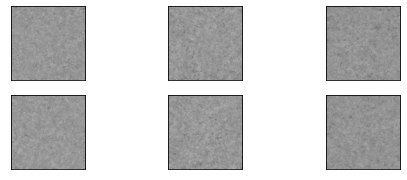

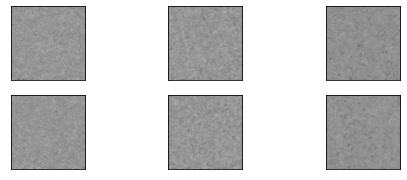

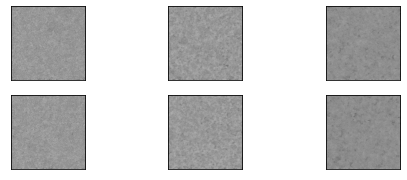

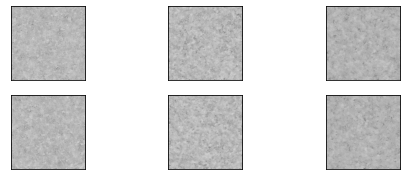

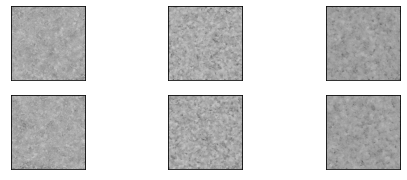

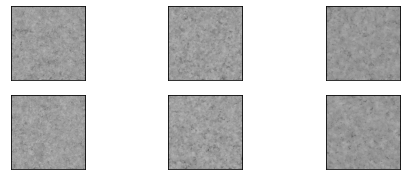

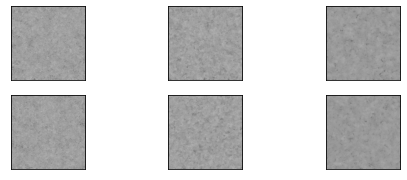

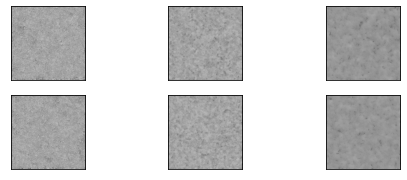

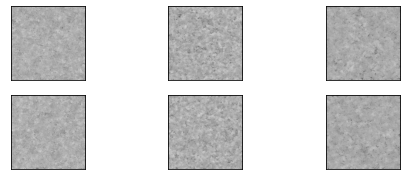

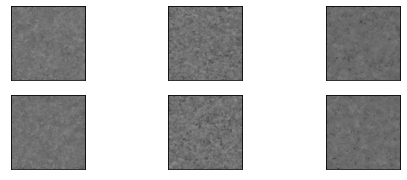

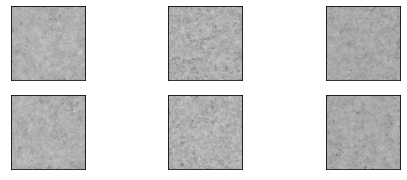

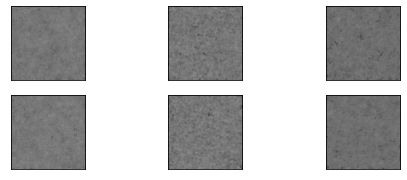

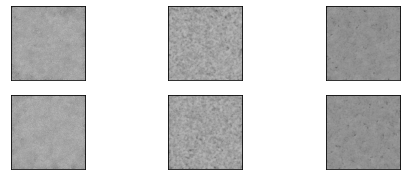

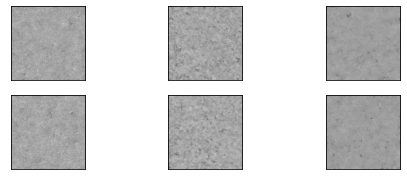

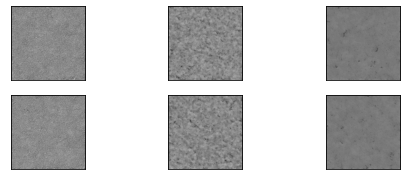

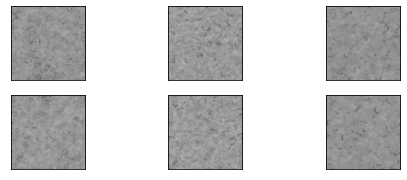

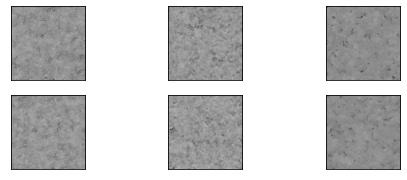

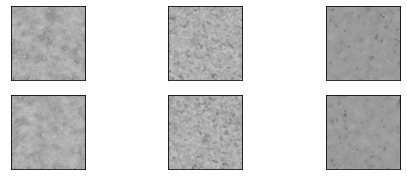

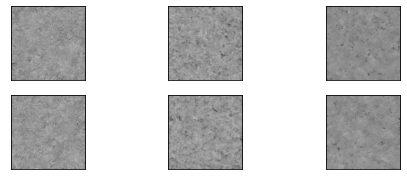

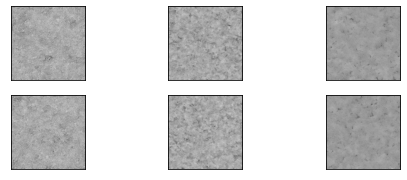

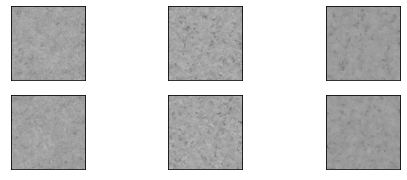

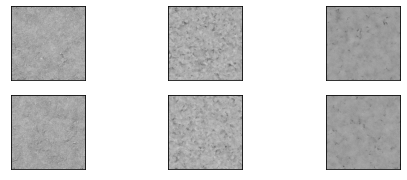

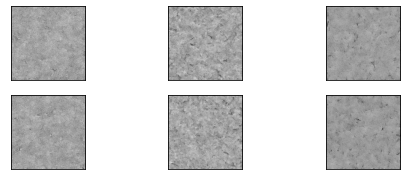

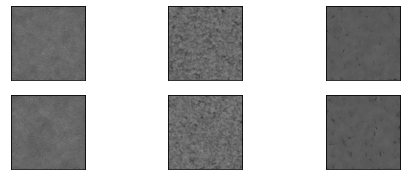

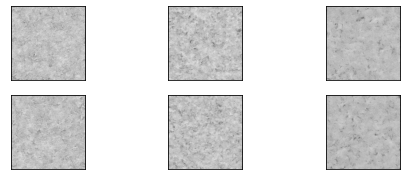

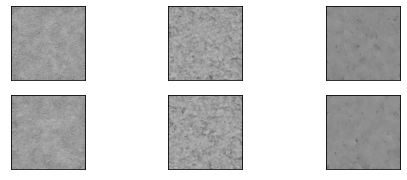

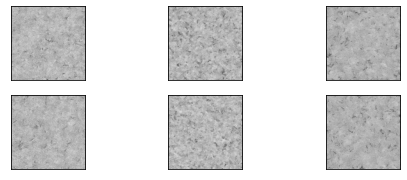

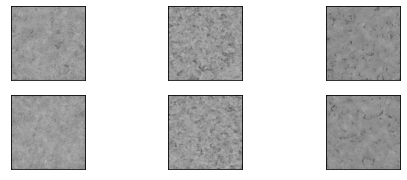

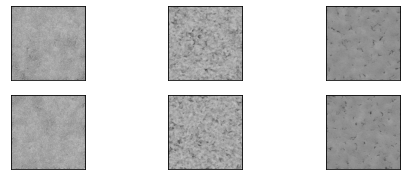

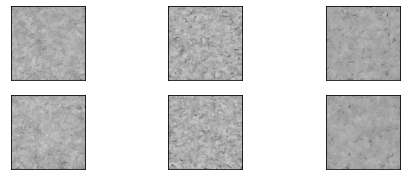

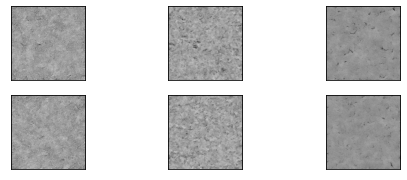

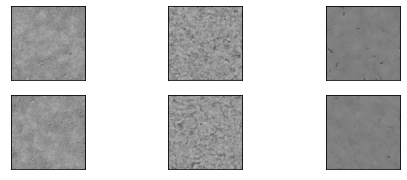

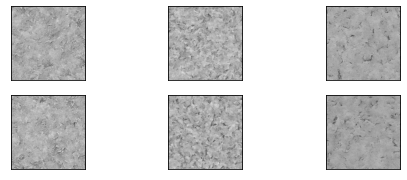

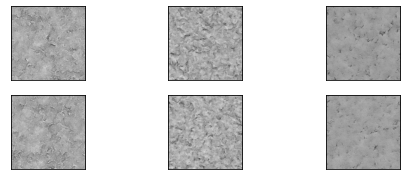

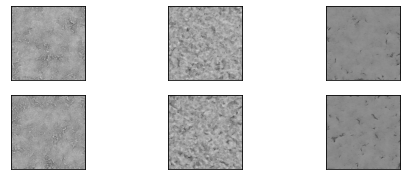

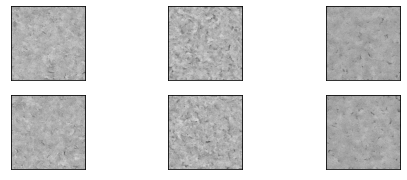

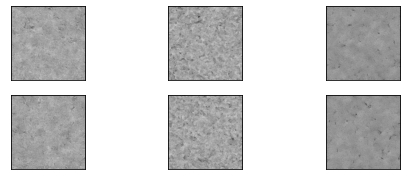

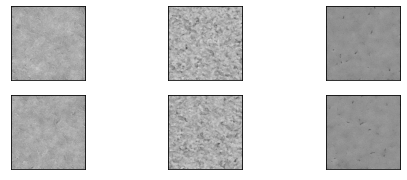

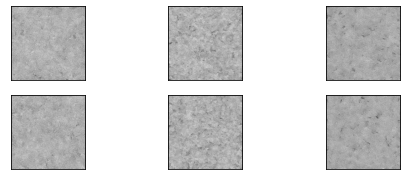

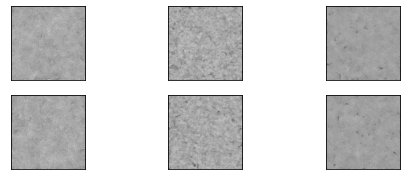

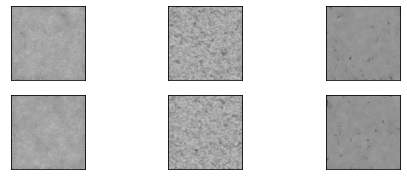

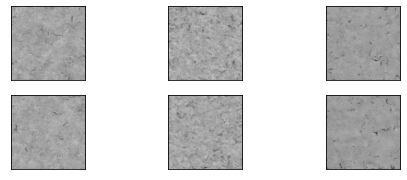

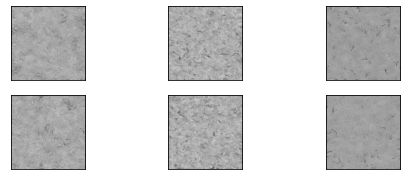

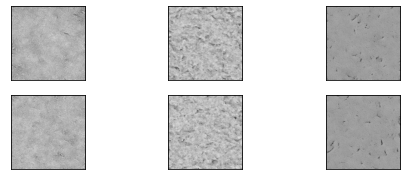

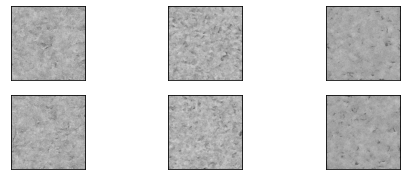

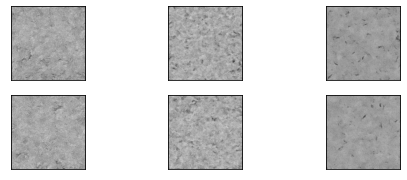

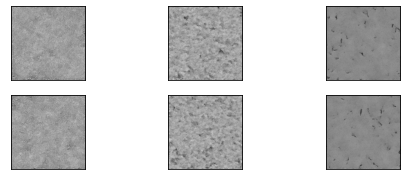

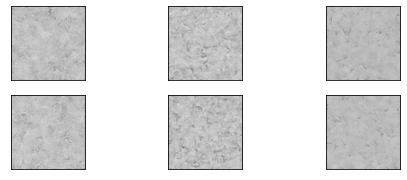

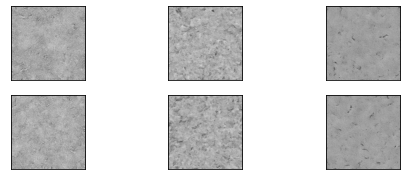

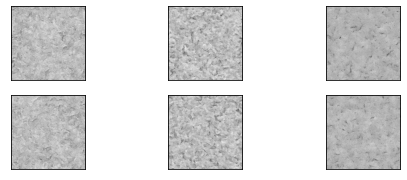

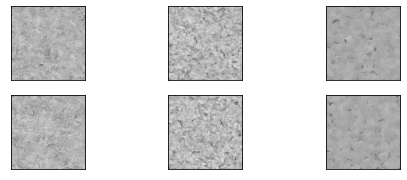

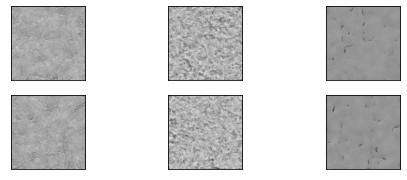

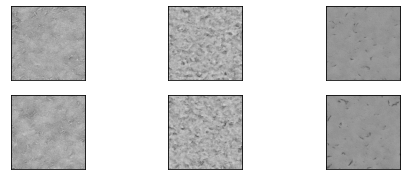

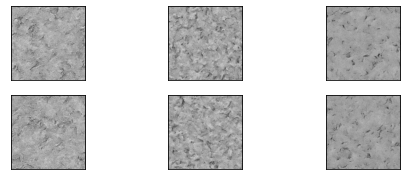

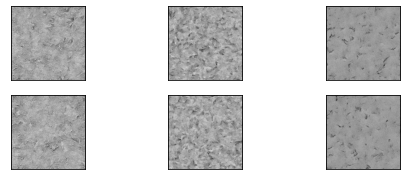

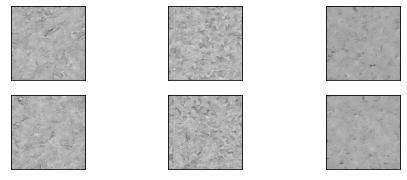

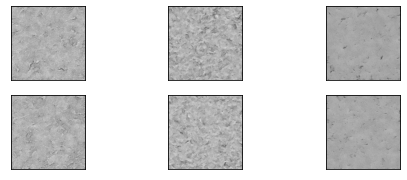

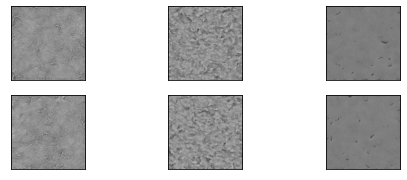

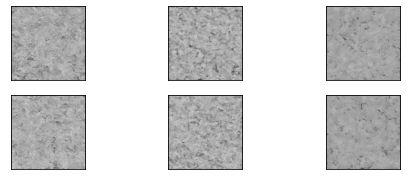

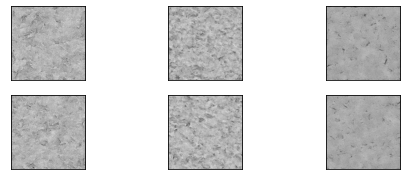

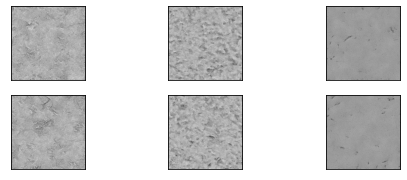

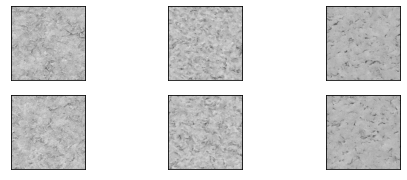

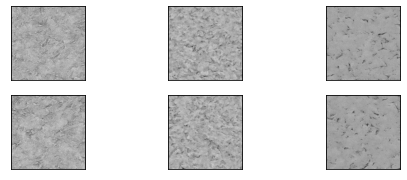

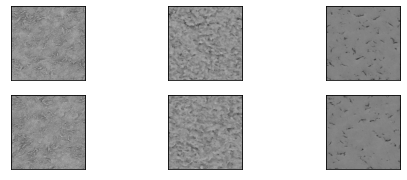

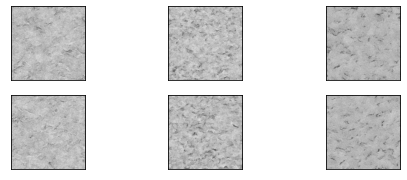

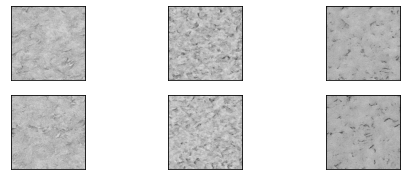

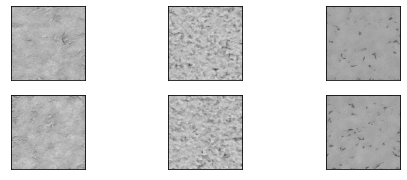

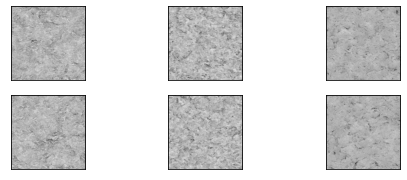

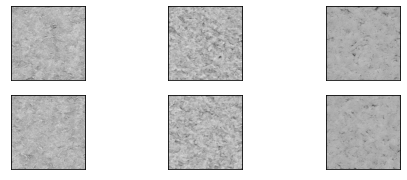

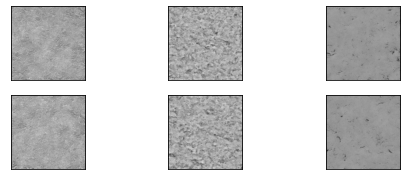

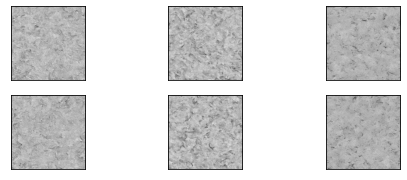

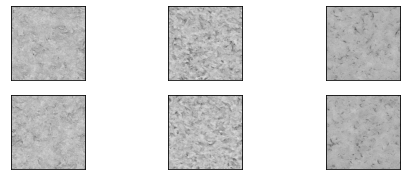

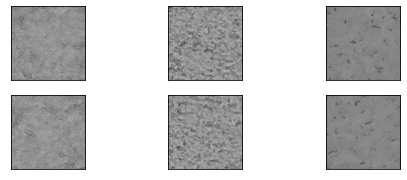

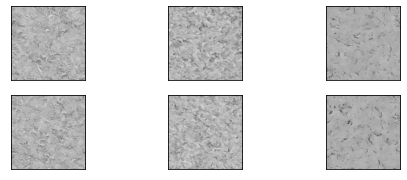

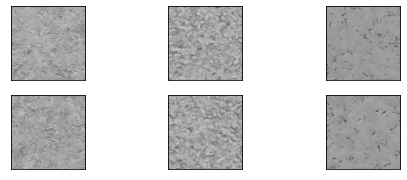

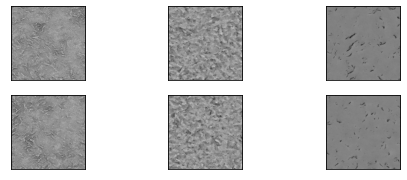

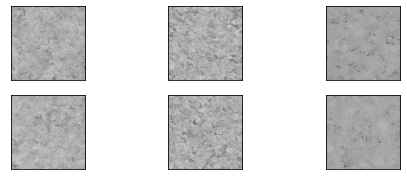

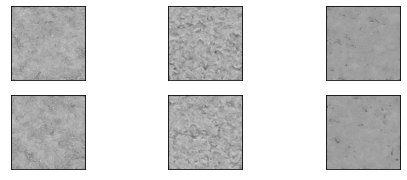

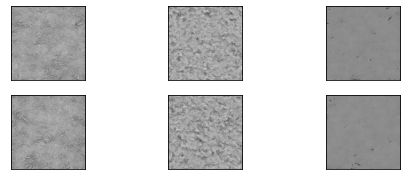

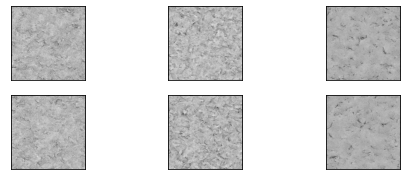

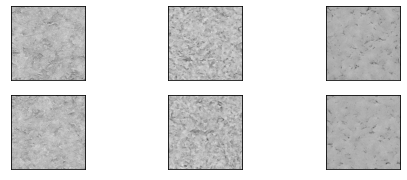

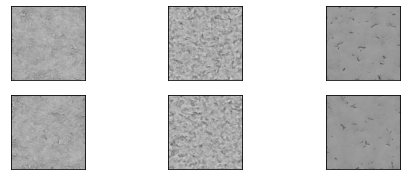

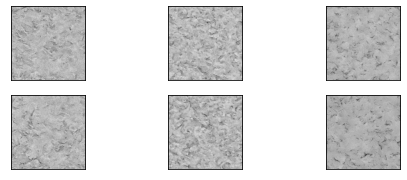

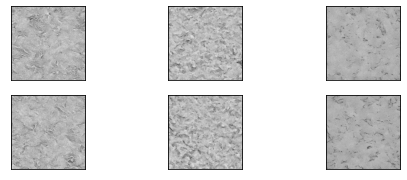

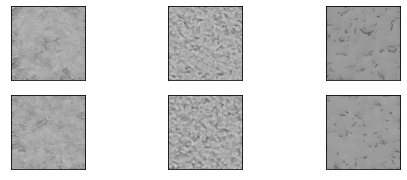

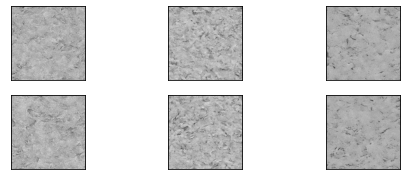

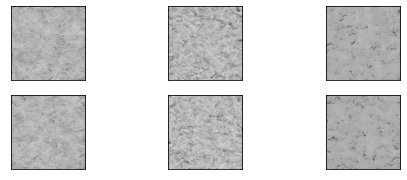

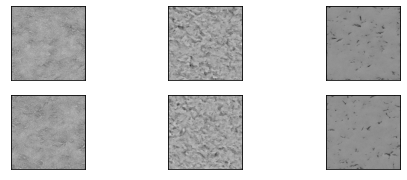

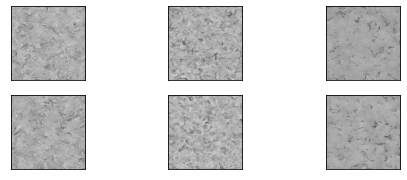

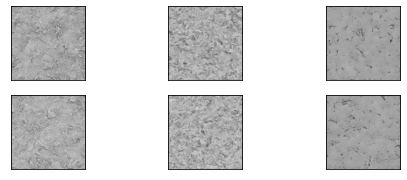

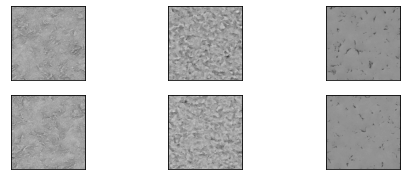

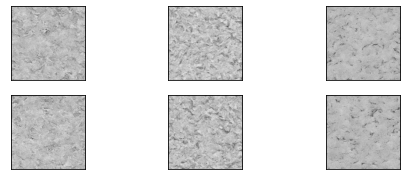

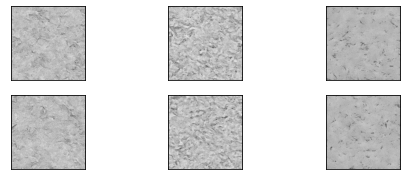

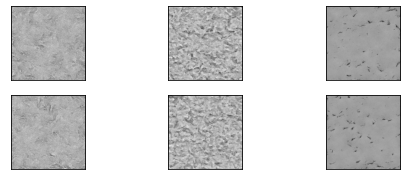

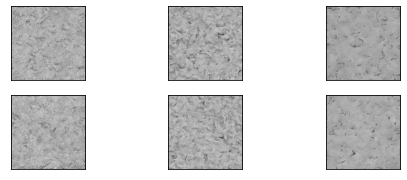

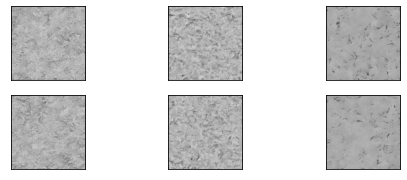

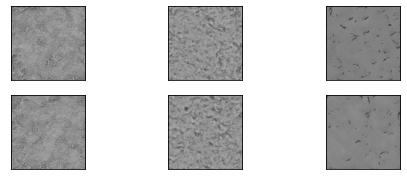

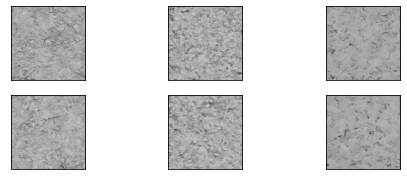

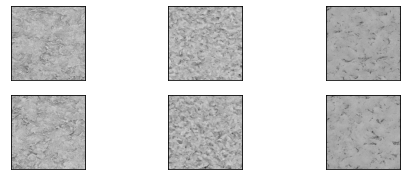

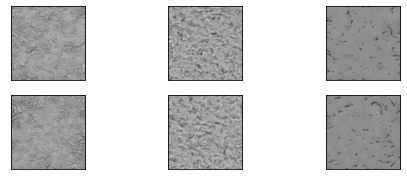

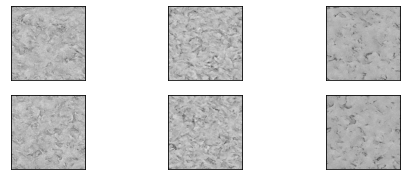

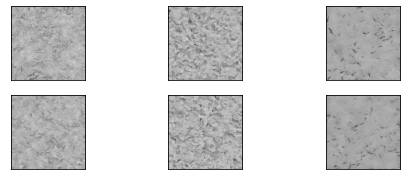

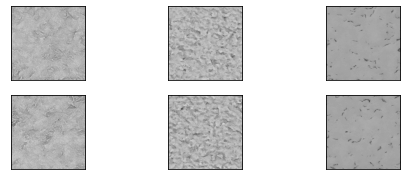

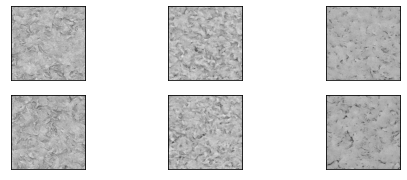

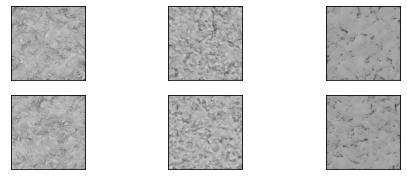

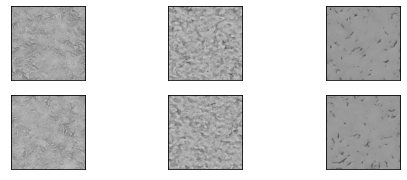

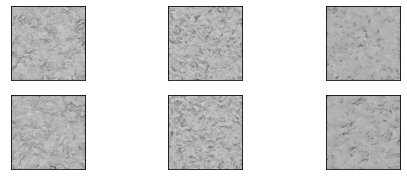

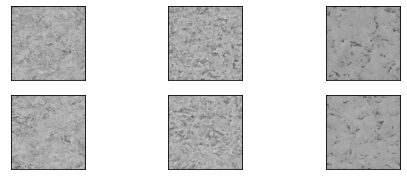

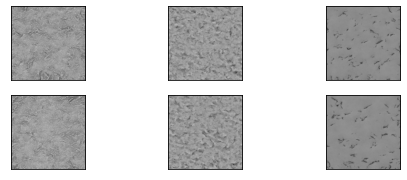

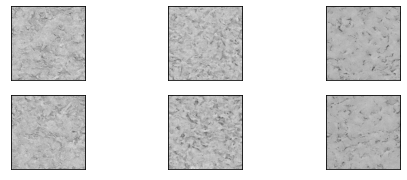

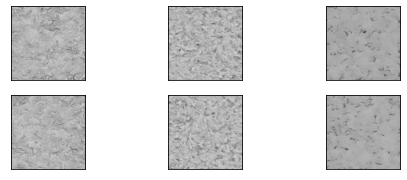

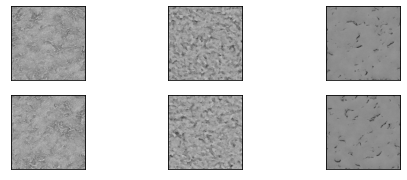

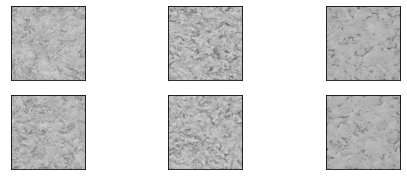

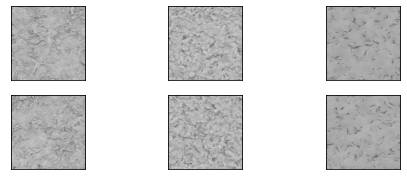

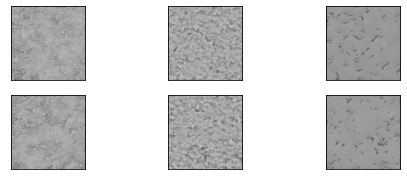

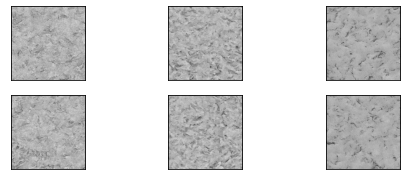

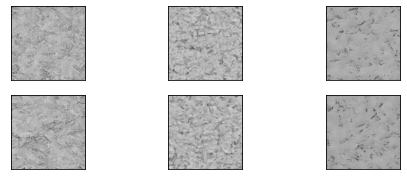

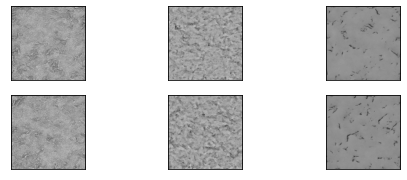

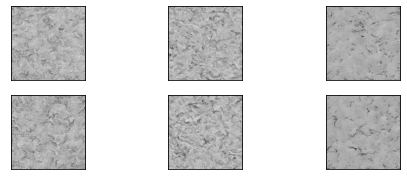

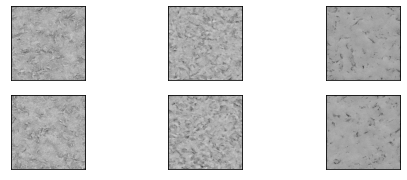

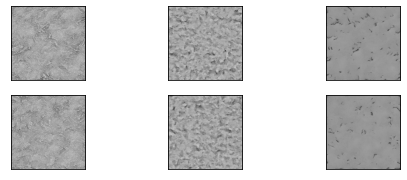

In [13]:
from torchvision.transforms import Compose, ToTensor, Lambda, Grayscale
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.optim import Adam 


# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root, transform=transform)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def __len__(self):
        return len(self.dataset)


def train_custom_dataset():
    # Hardcoding these here
    n_epoch = 250
    batch_size = 5
    n_T = 200
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    print()
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    n_classes = 3  # Update to the number of classes in your dataset
    n_feat = 128
    lrate = 1e-4
    save_model = True
    save_dir = '/home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/results/'
    ws_test = [0.0, 0.5, 2.0]  # Strength of generative guidance

    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    ddpm.to(device)

    # Define transformations
    transform = Compose([ToTensor(), Lambda(lambda x: (x - 0.5) * 2)])
    
    tf = transforms.Compose([transforms.ToTensor()])

    # Specify the path to the dataset
    dataset_path = r'/home/grads/a/adithyaa1996/Research/Guided_Diffusion_MS/Dataset'
    
    # Create a custom dataset using ImageFolder
    total_dataset = ImageFolder(root=dataset_path, transform=Compose([ToTensor(), Grayscale(num_output_channels=1)]))

    # Create DataLoader
    batch_size = 5
    dataloader = DataLoader(total_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    
    optim = Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # Linear learning rate decay
        optim.param_groups[0]['lr'] = lrate * (1 - ep / n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 2*n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(n_sample, (1, 256, 256), device, guide_w=w)

                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample/n_classes)):
                        try: 
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k+(j*n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all*-1 + 1, nrow=3)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print('saved image at ' + save_dir + f"image_ep{ep}_w{w}.png")

                if ep%5==0 or ep == int(n_epoch-1):
                    # create gif of images evolving over time, based on x_gen_store
                    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,4))
                    def animate_diff(i, x_gen_store):
                        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                        plots = []
                        for row in range(int(n_sample/n_classes)):
                            for col in range(n_classes):
                                axs[row, col].clear()
                                axs[row, col].set_xticks([])
                                axs[row, col].set_yticks([])
                                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                                plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                        return plots
                    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])    
                    ani.save(save_dir + f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                    print('saved image at ' + save_dir + f"gif_ep{ep}_w{w}.gif")
        
        # optionally save model
        if save_model and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), save_dir + 'saved_models/' +f"model_{ep}.pth")
            print('saved model at ' + save_dir + 'saved_models/' +  f"model_{ep}.pth")

if __name__ == "__main__":
    train_custom_dataset()